# Classificação da morfologia do esperma humano baseada em DCNN

#### Daniel Falci

Escrever um texto legal depois

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [2]:
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os
%matplotlib inline


# Pré processamento das imagens

As imagens lidas na base de dados estão originalmente dispostas em um formato 131x131. Existem 

* Crop 128x128 ou Stretch para 128x128

In [3]:
imagePaths = sorted(list(paths.list_images('HuSHem')))
random.seed(35)
random.shuffle(imagePaths)


HuSHem/01_Normal/image_018.BMP


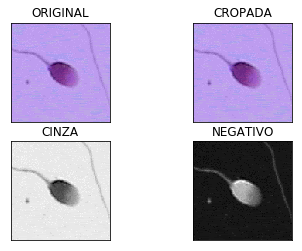

HuSHem/02_Tapered/image_024.BMP


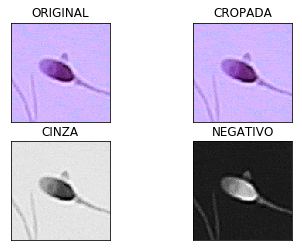

HuSHem/01_Normal/image_031.BMP


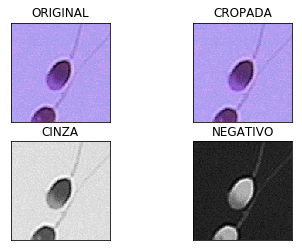

HuSHem/03_Pyriform/image_037.BMP


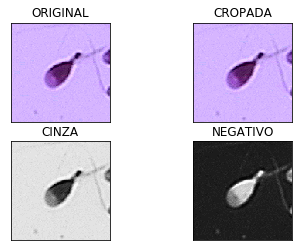

HuSHem/04_Amorphous/image_009.BMP


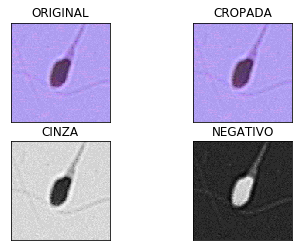

imagens carregadas 216


In [4]:
data = []
labels = []

def showImage(image, label):
    print label
    plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.show()
    
    
def crop(img, area):
    def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
        img = cv2.copyMakeBorder(img, - min(0, y1), max(y2 - img.shape[0], 0), -min(0, x1), max(x2 - img.shape[1], 0),cv2.BORDER_REPLICATE)
        y2 += -min(0, y1)
        y1 += -min(0, y1)
        x2 += -min(0, x1)
        x1 += -min(0, x1)
        return img, x1, x2, y1, y2
    
    
    x1,y1,x2,y2 = area
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
    return img[y1:y2, x1:x2, :]

def negativo(image):
    return (255-image)

def show_img_hist(img):
    plt.hist(img.flatten(),256,[0,256])
    plt.show()
    
def linear_contrast(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    
    return cdf[img]

def threshold(image):
    ret,image = cv2.threshold(image,70,90,cv2.THRESH_TOZERO)
    return image

    
    
def do_pipeline(filename, image, show_sample=False):
    titles = []
    samples = []
    
    def add_img(img, title):
        titles.append(title)
        samples.append(img)
    
    add_img(image, 'ORIGINAL')
    
    if not image.shape == (131, 131, 3):
        image = cv2.resize(image, (128, 128))
        
        
    cropped = crop(image, (1, 1, 129, 129))
    
    add_img(cropped, 'CROPADA')
    
    gray_scale = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    
    add_img(gray_scale, 'CINZA')
    

    neg = negativo(gray_scale)
    
    add_img(neg, 'NEGATIVO')
    
    if show_sample:
        print filename
        for i in xrange(len(samples)):
            plt.subplot(2,2,i+1),plt.imshow(samples[i],'gray')
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])
        plt.show()
#         plt.hist(neg.flatten(),256,[0,256])
#         plt.title('HISTOGRAMA')
#         plt.xticks([0, 255])
#         plt.show()
        
    return neg
        
    

i=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    data.append(img_to_array(do_pipeline(imagePath, cv2.imread(imagePath, cv2.IMREAD_UNCHANGED), True if i < 5 else False)))
    labels.append(label)
    
    
    i+=1

print 'imagens carregadas {qu}'.format(qu=len(data))
    
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [5]:
def img_partition():
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return (x_train, y_train, x_test, y_test)

def get_normalized_data():
    x_train, y_train, x_test, y_test = img_partition()
    x_train = x_train /255
    x_test = x_test / 255
    return (x_train, y_train, x_test, y_test)    

x_train, y_train, x_test, y_test = img_partition()

## Etapa de geração de imagens

(1, 128, 128, 1)


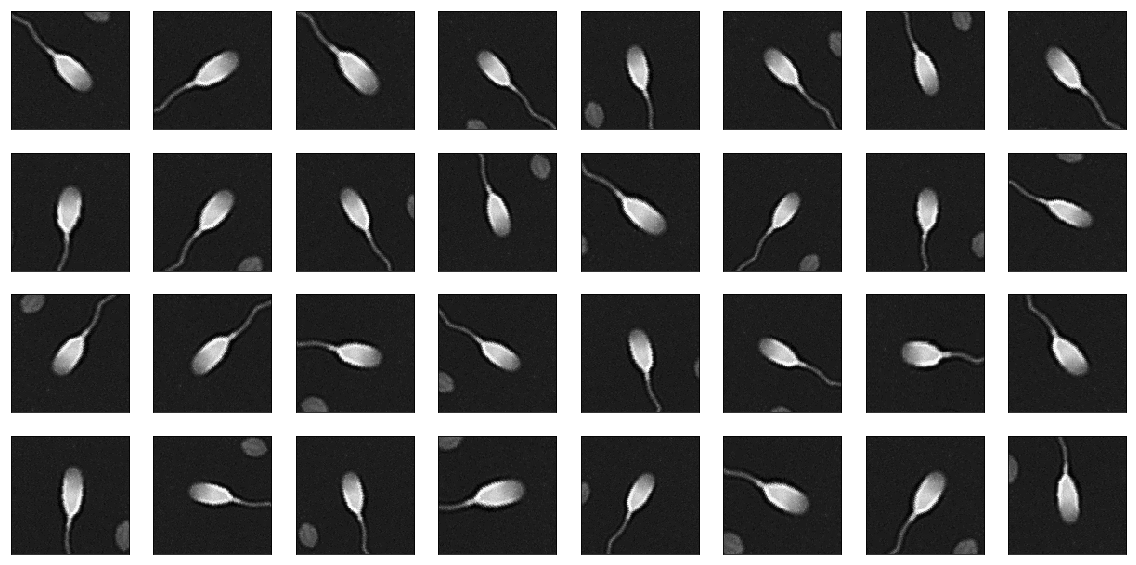

In [6]:

# generator = ImageDataGenerator(rotation_range=180)
# generator = ImageDataGenerator(zoom_range=0.15, fill_mode="reflect")
generator = ImageDataGenerator(rotation_range=180, horizontal_flip=True, zoom_range=0.15, fill_mode="reflect")
generator.fit(x_train)

plt.rcParams['figure.figsize'] = [20, 10]

imgs = []

teste = x_train[:1]

print teste.shape
batches = 0
nimg = 0
for gen in generator.flow(teste, batch_size=32):
    batches +=1
    for x in gen:
        img = np.asarray(x).reshape((128, 128))
        plt.subplot(4,8,nimg+1),plt.imshow(img,'gray', animated=True)
        plt.xticks([]),plt.yticks([])
        nimg+=1
    if batches >= 32:
        plt.show()
        break



In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(8, 8), strides=(1, 1), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.15))
model.add(Dense(4, activation='softmax'))

In [8]:
import keras
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 121, 121, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
__________

Agora vamos para o modelo em sí

# Treinando o modelo



In [9]:
x_train, y_train, x_test, y_test = get_normalized_data()
augX = ImageDataGenerator(rotation_range=180, horizontal_flip=True, zoom_range=0.15, fill_mode="reflect")
augX.fit(x_train)

history = model.fit_generator(augX.flow(x_train, y_train, batch_size=32), steps_per_epoch= len(x_train) //4, epochs=200, verbose=1, validation_data=(x_test, y_test))

Epoch 1/200
43/43 [==============================] - 3s - loss: 1.3832 - acc: 0.2887 - val_loss: 1.2789 - val_acc: 0.3409
Epoch 2/200
43/43 [==============================] - 2s - loss: 1.2276 - acc: 0.4333 - val_loss: 1.0869 - val_acc: 0.4545
Epoch 3/200
43/43 [==============================] - 2s - loss: 1.0983 - acc: 0.4989 - val_loss: 1.1009 - val_acc: 0.5227
Epoch 4/200
43/43 [==============================] - 2s - loss: 1.0412 - acc: 0.5322 - val_loss: 0.9701 - val_acc: 0.5909
Epoch 5/200
43/43 [==============================] - 2s - loss: 1.0032 - acc: 0.5803 - val_loss: 0.9398 - val_acc: 0.5909
Epoch 6/200
43/43 [==============================] - 2s - loss: 0.9943 - acc: 0.5724 - val_loss: 0.9213 - val_acc: 0.5909
Epoch 7/200
43/43 [==============================] - 2s - loss: 0.8931 - acc: 0.6152 - val_loss: 0.8319 - val_acc: 0.6136
Epoch 8/200
43/43 [==============================] - 2s - loss: 0.8328 - acc: 0.6455 - val_loss: 0.9076 - val_acc: 0.5909
Epoch 9/200
43/43 [=====

43/43 [==============================] - 2s - loss: 0.0835 - acc: 0.9736 - val_loss: 0.1254 - val_acc: 0.9773
Epoch 134/200
43/43 [==============================] - 2s - loss: 0.0917 - acc: 0.9606 - val_loss: 0.0681 - val_acc: 0.9545
Epoch 135/200
43/43 [==============================] - 2s - loss: 0.1130 - acc: 0.9608 - val_loss: 0.1982 - val_acc: 0.9318
Epoch 136/200
43/43 [==============================] - 2s - loss: 0.0957 - acc: 0.9593 - val_loss: 0.0968 - val_acc: 0.9318
Epoch 137/200
43/43 [==============================] - 2s - loss: 0.0666 - acc: 0.9760 - val_loss: 0.2084 - val_acc: 0.9318
Epoch 138/200
43/43 [==============================] - 2s - loss: 0.0717 - acc: 0.9743 - val_loss: 0.0343 - val_acc: 1.0000
Epoch 139/200
43/43 [==============================] - 2s - loss: 0.0799 - acc: 0.9746 - val_loss: 0.2472 - val_acc: 0.9091
Epoch 140/200
43/43 [==============================] - 2s - loss: 0.0714 - acc: 0.9750 - val_loss: 0.2050 - val_acc: 0.9091
Epoch 141/200
43/43 [=

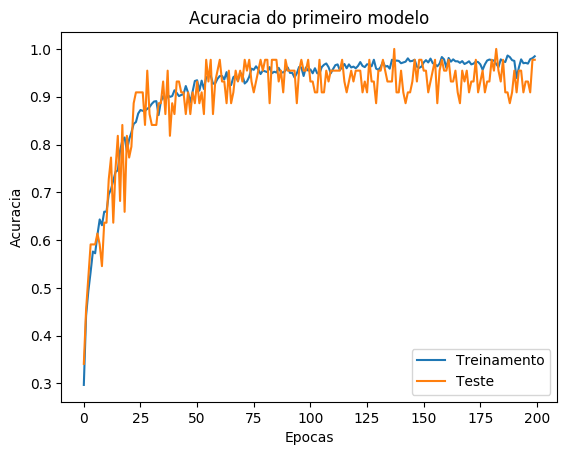

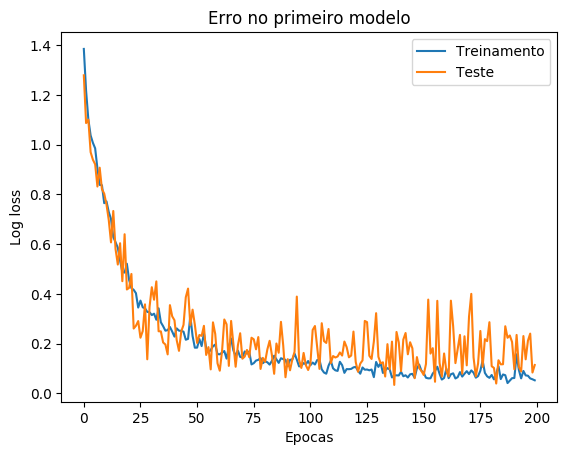

In [10]:
plt.rcdefaults() 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Acuracia do primeiro modelo')
plt.ylabel('Acuracia')
plt.xlabel('Epocas')
plt.legend(['Treinamento', 'Teste'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro no primeiro modelo')
plt.ylabel('Log loss')
plt.xlabel('Epocas')
plt.legend(['Treinamento', 'Teste'], loc='upper right')
plt.show()

# E agora? 

## arrumar o outro dataset? só escrever o artigo?


In [11]:
import tensorflow as tf

x = tf.placeholder(tf.float32, shape=[None, 128*128], name='x_train')
x_image = tf.reshape(x, [-1, 128, 128, 1])

y_true = tf.placeholder(tf.float32, shape=[None, 4], name='y_train')
y_true_cls = tf.argmax(y_true, dimension=1)

def conv(input, num_input_channels, filter_size, num_filters, name):
    with tf.variable_scope(name) as scope:
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
        layer += biases
        
        return layer, weights
    
def max_pool(input, name):
    with tf.variable_scope(name) as scope:
        layer = tf.nn.max_pool(value=input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        return layer
    
def relu_l(input, name):
    with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        return layer
    
def dense(input, num_inputs, num_outputs, name):
    with tf.variable_scope(name) as scope:
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        layer = tf.matmul(input, weights) + biases
        return layer

### continuar com a implementação depois